# Emergence of the Color Manifold in Qwen2.5-VL

## Neural Scan: From Raw Activations to Causal Geometry

This notebook investigates whether Qwen2.5-VL learns a **circular hue manifold** as an internal abstraction. We perform a layer-wise neural scan, compare manifold hypotheses, and test causal steering in latent space.

### Design note 
We used:
- Multiple dataset contexts (`qwen_full_scan.pkl` and `qwen_wild_scan.pkl`)
- Cross-validated shape ranking (`discover_manifolds`)
- Aggregated summary across runs (mean and consistency)
- Geometry-aware arbitration for periodic variables (hue seam closure)

The goal is not only best numeric score, but a topology that is faithful to full 0-360 hue periodicity.

## 1) Environment Setup


In [58]:
%matplotlib inline

import colorsys
import re
import sys
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "supervised-multidimensional-scaling" / "smds").exists():
            return candidate
    raise FileNotFoundError("Could not locate repository root containing supervised-multidimensional-scaling/smds")

repo_root = find_repo_root(Path.cwd().resolve())
smds_root = repo_root / "supervised-multidimensional-scaling"
if str(smds_root) not in sys.path:
    sys.path.insert(0, str(smds_root))

from smds import ComputedSMDSParametrization, SupervisedMDS, UserProvidedSMDSParametrization
from smds.pipeline.discovery_pipeline import discover_manifolds
import smds.shapes.continuous_shapes as shapes

plt.style.use("seaborn-v0_8-whitegrid")
print(f"Repository root: {repo_root}")


Repository root: /Users/vinayakjoshi/Documents/Masters/Sem_3/DASP/Code


## 2) Data Preview: Simple vs Wild Color Stimuli

Before touching activations, we visualize source images for both scans:
- `qwen_full_scan.pkl`: simple color stimuli
- `qwen_wild_scan.pkl`: in-the-wild textured stimuli

This gives the reader immediate visual intuition for the two regimes.

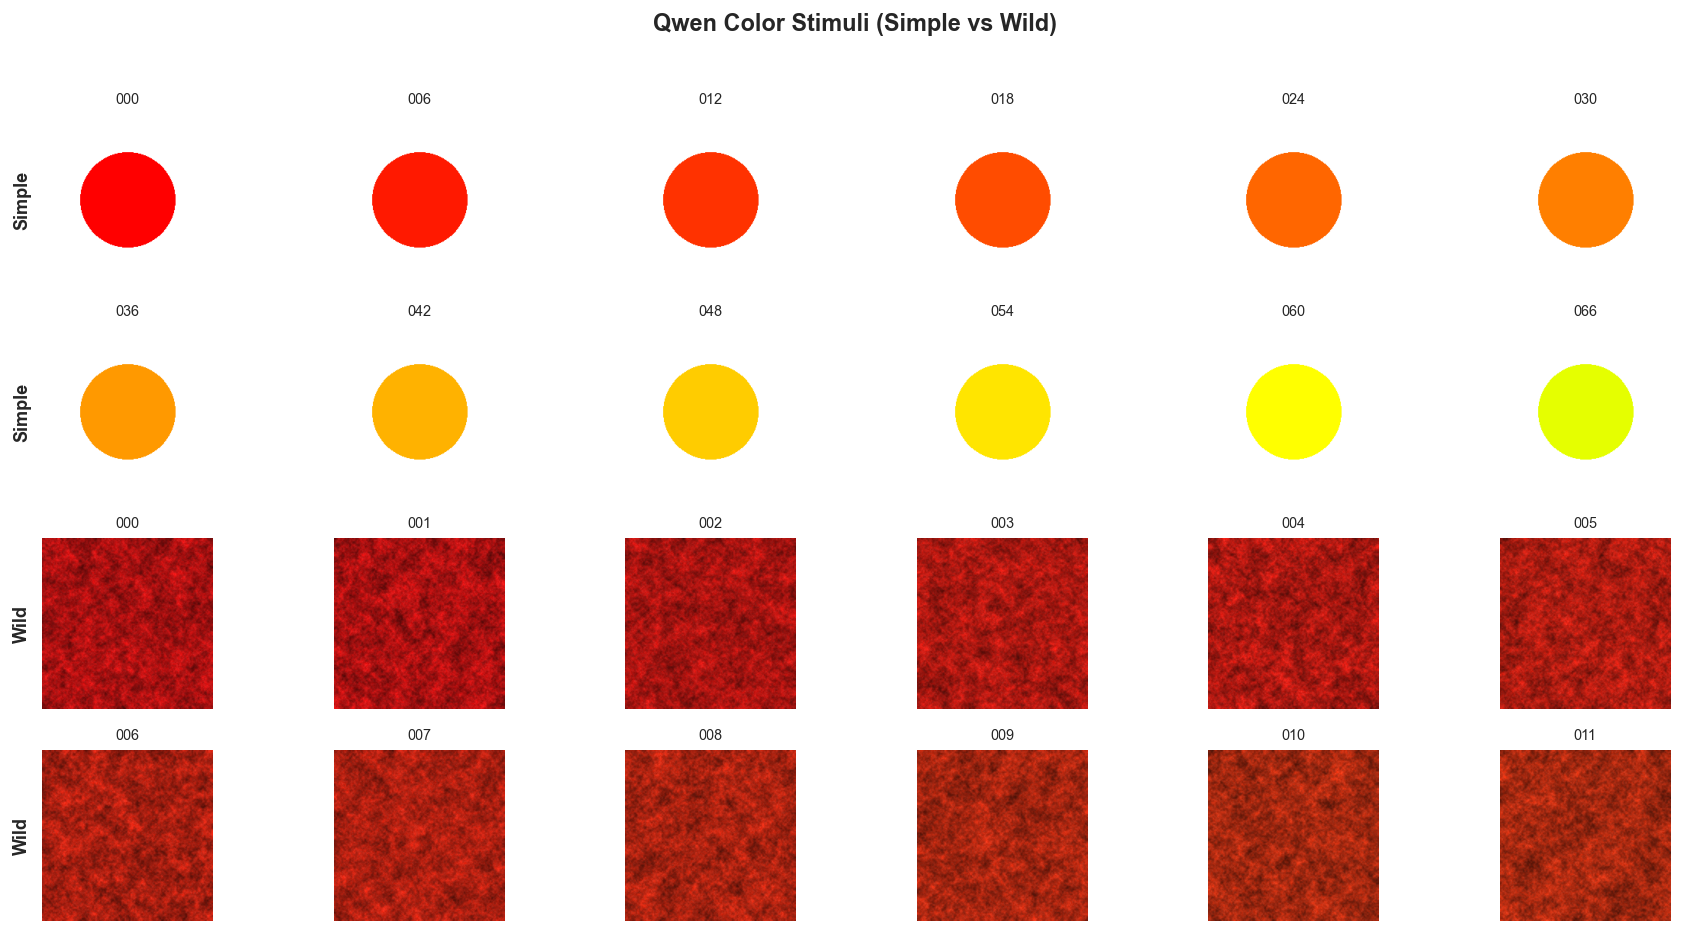

In [59]:
def parse_hue_from_name(path: Path) -> int:
    match = re.search(r"hue_(\d+)", path.stem)
    return int(match.group(1)) if match else 10**9

def collect_images(dir_candidates: list[Path], max_images: int = 12) -> list[Path]:
    for directory in dir_candidates:
        if directory.exists():
            images = sorted(directory.glob("hue_*.png"), key=parse_hue_from_name)
            if images:
                return images[:max_images]
    return []

simple_candidates = [
    repo_root / "experiments" / "vlm_color" / "color_manifold",
    repo_root / "experiments" / "Qwen" / "color_manifold",
]
wild_candidates = [
    repo_root / "experiments" / "vlm_color" / "wild_manifold",
    repo_root / "experiments" / "Qwen" / "wild_manifold",
]

simple_imgs = collect_images(simple_candidates, max_images=12)
wild_imgs = collect_images(wild_candidates, max_images=12)

if not simple_imgs and not wild_imgs:
    print("No image folders found for preview. Continuing with scan data only.")
else:
    n_cols = 6
    fig, axes = plt.subplots(4, n_cols, figsize=(14, 7), dpi=130)
    axes = np.asarray(axes).reshape(4, n_cols)

    def render_row(row_axes: np.ndarray, image_paths: list[Path], title: str) -> None:
        for idx, ax in enumerate(row_axes):
            if idx < len(image_paths):
                with Image.open(image_paths[idx]) as img:
                    ax.imshow(np.asarray(img))
                ax.set_title(f"{parse_hue_from_name(image_paths[idx]):03d}", fontsize=8)
            ax.axis("off")
        row_axes[0].text(
            -0.12,
            0.5,
            title,
            transform=row_axes[0].transAxes,
            rotation=90,
            va="center",
            ha="center",
            fontsize=10,
            weight="bold",
        )

    render_row(axes[0], simple_imgs[:6], "Simple")
    render_row(axes[1], simple_imgs[6:12], "Simple")
    render_row(axes[2], wild_imgs[:6], "Wild")
    render_row(axes[3], wild_imgs[6:12], "Wild")

    plt.suptitle("Qwen Color Stimuli (Simple vs Wild)", fontsize=13, weight="bold", y=1.02)
    plt.tight_layout()
    plt.show()


## 3) Load Both Scans with `joblib`

We load both files explicitly and keep them as separate experimental domains.

In [60]:
def resolve_scan_path(filename: str) -> Path:
    candidates = [
        repo_root / "experiments" / "vlm_color" / filename,
        repo_root / "experiments" / "Qwen" / filename,
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    checked = "\n".join(str(path) for path in candidates)
    raise FileNotFoundError(f"Missing required scan file {filename}. Checked:\n{checked}")

scan_files = {
    "full_simple": "qwen_full_scan.pkl",
    "wild_textured": "qwen_wild_scan.pkl",
}

scans = {}
for tag, filename in scan_files.items():
    path = resolve_scan_path(filename)
    payload = joblib.load(path)
    layer_data = payload["layer_data"]
    layers = sorted(int(layer) for layer in layer_data.keys())
    angles_deg = np.asarray(payload["angles"], dtype=np.float64)
    hue_norm = (angles_deg % 360.0) / 360.0

    scans[tag] = {
        "path": path,
        "payload": payload,
        "layer_data": layer_data,
        "layers": layers,
        "angles_deg": angles_deg,
        "hue_norm": hue_norm,
    }

summary_rows = []
for tag, bundle in scans.items():
    sample = np.asarray(bundle["layer_data"][bundle["layers"][0]], dtype=np.float64)
    summary_rows.append(
        {
            "dataset": tag,
            "file": str(bundle["path"]),
            "n_samples": int(bundle["angles_deg"].shape[0]),
            "embedding_dim": int(sample.shape[1]),
            "n_layers": int(len(bundle["layers"])),
            "min_layer": int(min(bundle["layers"])),
            "max_layer": int(max(bundle["layers"])),
            "angle_min": float(bundle["angles_deg"].min()),
            "angle_max": float(bundle["angles_deg"].max()),
        }
    )

summary_df = pd.DataFrame(summary_rows)
display(summary_df)


,dataset,file,n_samples,embedding_dim,n_layers,min_layer,max_layer,angle_min,angle_max
0,full_simple,/Users/vinayakjoshi/Documents/Masters/Sem_3/DA...,60,2048,28,0,27,0.0,354.0
1,wild_textured,/Users/vinayakjoshi/Documents/Masters/Sem_3/DA...,360,2048,28,0,27,0.0,359.0


## 4) Helper Functions for Neural Scan and Topology Arbitration

Topological stress is computed as `1 - score`.
For periodic variables, we also evaluate **seam closure**: the distance between low-hue and high-hue endpoints in learned coordinates, normalized by local neighbor spacing.

In [61]:
METRIC_COL = "mean_scale_normalized_stress"
CANDIDATE_SHAPES = [shapes.CircularShape(), shapes.SemicircularShape(), shapes.EuclideanShape()]
SHAPE_FACTORIES = {
    "CircularShape": lambda: shapes.CircularShape(),
    "SemicircularShape": lambda: shapes.SemicircularShape(),
    "EuclideanShape": lambda: shapes.EuclideanShape(),
}

def fit_shape_smds(X: np.ndarray, y: np.ndarray, shape_obj) -> SupervisedMDS:
    stage_1 = ComputedSMDSParametrization(manifold=shape_obj, n_components=2)
    model = SupervisedMDS(stage_1=stage_1, alpha=1e-4)
    model.fit(X, y)
    return model

def run_layerwise_circular_stress(layer_data: dict, layers: list[int], hue_norm: np.ndarray) -> pd.DataFrame:
    records = []
    for layer in layers:
        X_layer = np.asarray(layer_data[layer], dtype=np.float64)
        model = fit_shape_smds(X_layer, hue_norm, shapes.CircularShape())
        score = float(model.score(X_layer, hue_norm))
        records.append({"layer": layer, "score": score, "stress": 1.0 - score})
    return pd.DataFrame(records).sort_values("layer").reset_index(drop=True)

def periodic_train_test_split(
    angles_deg: np.ndarray,
    test_fraction: float = 0.2,
    offset: int = 0,
) -> tuple[np.ndarray, np.ndarray]:
    """Deterministic split preserving coverage around the hue circle."""
    angles = np.asarray(angles_deg, dtype=np.float64)
    if angles.ndim != 1:
        raise ValueError("angles_deg must be a 1D array")

    n = angles.shape[0]
    if n < 8:
        raise ValueError(f"Not enough samples for stable split: n={n}")

    order = np.argsort(angles)
    step = max(int(round(1.0 / test_fraction)), 2)

    test_mask = np.zeros(n, dtype=bool)
    test_mask[order[offset::step]] = True

    if test_mask.sum() == 0 or test_mask.sum() >= n:
        test_mask[:] = False
        test_mask[order[::step]] = True
    if test_mask.sum() >= n:
        test_mask[order[-1]] = False

    train_idx = np.where(~test_mask)[0]
    test_idx = np.where(test_mask)[0]
    return train_idx, test_idx

def discover_on_train(X_train: np.ndarray, y_train: np.ndarray, label: str) -> pd.DataFrame:
    n_folds = min(5, max(2, int(X_train.shape[0] // 10)))
    results_df, _ = discover_manifolds(
        X=X_train,
        y=y_train,
        shapes=CANDIDATE_SHAPES,
        n_folds=n_folds,
        n_jobs=1,
        save_results=False,
        create_png_visualization=False,
        clear_cache=True,
        experiment_name=f"qwen_color_train_{label}",
    )
    if results_df.empty or METRIC_COL not in results_df.columns:
        raise RuntimeError(f"Discovery failed for {label}.")
    return results_df.sort_values(METRIC_COL, ascending=False).reset_index(drop=True)

def seam_closure_ratio(coords: np.ndarray, angles_deg: np.ndarray) -> float:
    angles = np.asarray(angles_deg, dtype=np.float64)
    unique = np.unique(np.sort(angles))
    step = float(np.median(np.diff(unique))) if unique.size > 1 else 1.0
    low_value = float(unique.min())
    high_value = float(unique.max())

    low_idx = np.where(np.abs(angles - low_value) <= step / 2.0 + 1e-9)[0]
    high_idx = np.where(np.abs(angles - high_value) <= step / 2.0 + 1e-9)[0]

    low_center = coords[low_idx].mean(axis=0)
    high_center = coords[high_idx].mean(axis=0)
    seam_distance = float(np.linalg.norm(low_center - high_center))

    order = np.argsort(angles)
    sorted_coords = coords[order]
    local_steps = np.linalg.norm(sorted_coords[1:] - sorted_coords[:-1], axis=1)
    local_steps = local_steps[local_steps > 0]
    local_scale = float(np.median(local_steps)) if local_steps.size > 0 else 1.0

    return seam_distance / (local_scale + 1e-12)

def hue_coverage_ratio(angles_deg: np.ndarray) -> float:
    unique = np.unique(np.sort(np.asarray(angles_deg, dtype=np.float64)))
    if unique.size <= 1:
        return 0.0
    step = float(np.median(np.diff(unique)))
    span = float(unique.max() - unique.min() + step)
    return span / 360.0

def periodicity_score(closure_ratio: float) -> float:
    return float(np.exp(-closure_ratio))


## 5) Layer-wise Stress Scan for Both Domains

We run the circular stress scan independently on `full_simple` and `wild_textured`.

In [62]:
stress_tables = {}
optimal_rows = []

for dataset_name, bundle in scans.items():
    stress_df = run_layerwise_circular_stress(
        layer_data=bundle["layer_data"],
        layers=bundle["layers"],
        hue_norm=bundle["hue_norm"],
    )
    stress_tables[dataset_name] = stress_df
    best_idx = int(stress_df["stress"].idxmin())
    optimal_rows.append(
        {
            "dataset": dataset_name,
            "optimal_layer": int(stress_df.loc[best_idx, "layer"]),
            "min_stress": float(stress_df.loc[best_idx, "stress"]),
            "max_score": float(stress_df.loc[best_idx, "score"]),
        }
    )

optimal_layers_df = pd.DataFrame(optimal_rows).sort_values("dataset").reset_index(drop=True)
display(optimal_layers_df)


,dataset,optimal_layer,min_stress,max_score
0,full_simple,27,0.000006,0.999994
1,wild_textured,27,0.000001,0.999999


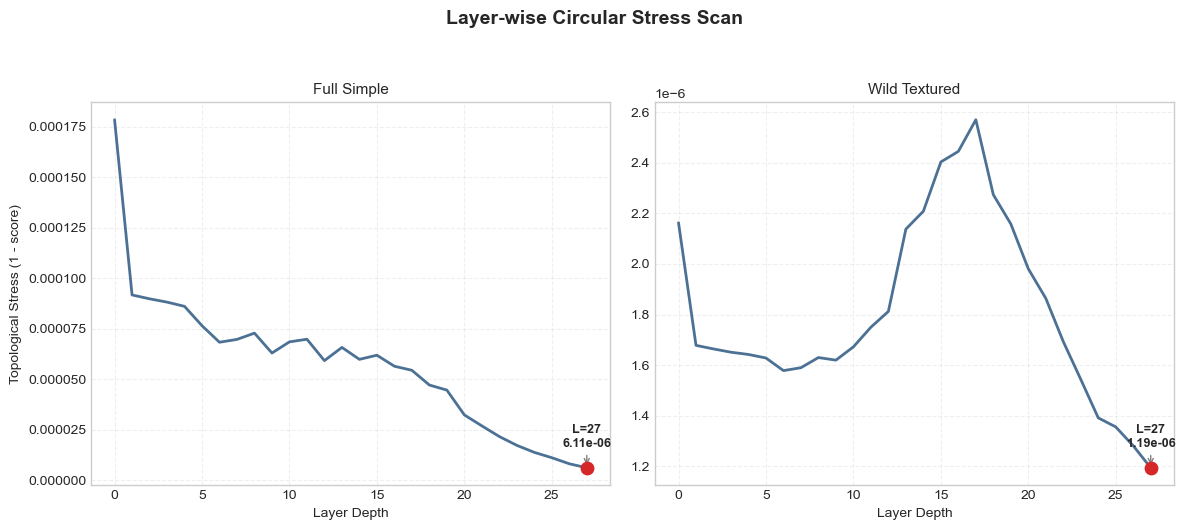

In [63]:
# Fixed: Removed sharey=True as the two datasets have different stress scales
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100) 

for ax, dataset_name in zip(axes, sorted(stress_tables.keys())):
    stress_df = stress_tables[dataset_name]
    row = optimal_layers_df[optimal_layers_df["dataset"] == dataset_name].iloc[0]
    opt_layer = int(row["optimal_layer"])
    opt_stress = float(row["min_stress"])

    ax.plot(stress_df["layer"], stress_df["stress"], color="#1f4e79", linewidth=2, alpha=0.8)
    ax.scatter([opt_layer], [opt_stress], color="#d62728", s=80, zorder=5)
    
    # Using 'offset points' prevents the Y-axis from stretching to infinity
    ax.annotate(
        f"L={opt_layer}\n{opt_stress:.2e}",
        xy=(opt_layer, opt_stress),
        xytext=(0, 15), 
        textcoords="offset points",
        ha='center',
        arrowprops={"arrowstyle": "->", "color": "gray"},
        fontsize=9,
        fontweight='bold'
    )
    
    ax.set_title(dataset_name.replace("_", " ").title(), fontsize=11)
    ax.set_xlabel("Layer Depth")
    ax.set_xticks(np.arange(0, 28, 5)) # Cleaner X-axis
    ax.grid(True, linestyle='--', alpha=0.3)

axes[0].set_ylabel("Topological Stress (1 - score)")
plt.suptitle("Layer-wise Circular Stress Scan", fontsize=14, weight="bold", y=1.05)
plt.tight_layout()
plt.show()

## 6) Shape Discovery with Train/Test Split at Each Optimal Layer

For each dataset domain:
- Build a deterministic hue-aware split (train/test)
- Run `discover_manifolds` on **train only**
- Refit each candidate shape on train and evaluate on held-out **test**

This prevents manifold selection from using the same samples for fitting and final evaluation.


In [64]:
split_rows = []
discovery_tables = {}
discovery_long_rows = []

for _, row in optimal_layers_df.iterrows():
    dataset_name = row["dataset"]
    optimal_layer = int(row["optimal_layer"])
    bundle = scans[dataset_name]

    X_opt = np.asarray(bundle["layer_data"][optimal_layer], dtype=np.float64)
    y_opt = np.asarray(bundle["hue_norm"], dtype=np.float64)
    angles_opt = np.asarray(bundle["angles_deg"], dtype=np.float64)

    train_idx, test_idx = periodic_train_test_split(angles_opt, test_fraction=0.2, offset=0)
    X_train, X_test = X_opt[train_idx], X_opt[test_idx]
    y_train, y_test = y_opt[train_idx], y_opt[test_idx]
    angles_test = angles_opt[test_idx]

    split_rows.append(
        {
            "dataset": dataset_name,
            "optimal_layer": optimal_layer,
            "n_total": int(X_opt.shape[0]),
            "n_train": int(X_train.shape[0]),
            "n_test": int(X_test.shape[0]),
        }
    )

    result_df = discover_on_train(X_train, y_train, label=dataset_name)
    discovery_tables[dataset_name] = result_df

    for _, r in result_df.iterrows():
        shape_name = str(r["shape"])
        if shape_name not in SHAPE_FACTORIES:
            continue

        model = fit_shape_smds(X_train, y_train, SHAPE_FACTORIES[shape_name]())
        test_score = float(model.score(X_test, y_test))
        test_coords = model.transform(X_test)
        closure = seam_closure_ratio(test_coords, angles_test)

        discovery_long_rows.append(
            {
                "dataset": dataset_name,
                "shape": shape_name,
                "train_cv_score": float(r[METRIC_COL]),
                "train_cv_std": float(r.get("std_scale_normalized_stress", np.nan)),
                "test_score": test_score,
                "test_closure_ratio": float(closure),
                "periodicity_score": periodicity_score(float(closure)),
                "coverage_ratio": float(hue_coverage_ratio(angles_opt)),
            }
        )

split_df = pd.DataFrame(split_rows).sort_values("dataset").reset_index(drop=True)
display(split_df)

discovery_long_df = pd.DataFrame(discovery_long_rows)
display(
    discovery_long_df.sort_values(["dataset", "test_score"], ascending=[True, False])
)


[WARNING] Less than 100 datapoints in X might lead to noisy results
Computed and cached CircularShape
Computed and cached SemicircularShape
Computed and cached EuclideanShape
Cache cleared
Computed and cached CircularShape
Computed and cached SemicircularShape
Computed and cached EuclideanShape
Cache cleared


,dataset,optimal_layer,n_total,n_train,n_test
0,full_simple,27,60,48,12
1,wild_textured,27,360,288,72


,dataset,shape,train_cv_score,train_cv_std,test_score,test_closure_ratio,periodicity_score,coverage_ratio
2,full_simple,CircularShape,0.505090,0.127904,0.918673,0.861393,0.422573,1.0
0,full_simple,SemicircularShape,0.687803,0.139644,0.800221,3.990236,0.018495,1.0
1,full_simple,EuclideanShape,0.683899,0.196602,0.646089,5.518191,0.004013,1.0
4,wild_textured,CircularShape,0.525899,0.067058,0.941483,1.727027,0.177812,1.0
3,wild_textured,SemicircularShape,0.596131,0.159132,0.796923,4.791612,0.008299,1.0
5,wild_textured,EuclideanShape,0.521948,0.233824,0.692043,5.068019,0.006295,1.0


## 7) Periodicity-Aware Topology Arbitration 

- Primary term: **held-out test score**
- Geometry term: **periodicity score** from seam closure

Composite:
`composite_score = 0.7 * test_score + 0.3 * periodicity_score`


In [65]:
arb_df = discovery_long_df.copy()
arb_df["composite_score"] = 0.7 * arb_df["test_score"] + 0.3 * arb_df["periodicity_score"]

display(arb_df.sort_values(["dataset", "composite_score"], ascending=[True, False]))


,dataset,shape,train_cv_score,train_cv_std,test_score,test_closure_ratio,periodicity_score,coverage_ratio,composite_score
2,full_simple,CircularShape,0.505090,0.127904,0.918673,0.861393,0.422573,1.0,0.769843
0,full_simple,SemicircularShape,0.687803,0.139644,0.800221,3.990236,0.018495,1.0,0.565704
1,full_simple,EuclideanShape,0.683899,0.196602,0.646089,5.518191,0.004013,1.0,0.453466
4,wild_textured,CircularShape,0.525899,0.067058,0.941483,1.727027,0.177812,1.0,0.712382
3,wild_textured,SemicircularShape,0.596131,0.159132,0.796923,4.791612,0.008299,1.0,0.560336
5,wild_textured,EuclideanShape,0.521948,0.233824,0.692043,5.068019,0.006295,1.0,0.486318


In [66]:
dataset_winners = []
for dataset_name, group in arb_df.groupby("dataset"):
    winner_row = group.sort_values("composite_score", ascending=False).iloc[0]
    dataset_winners.append(
        {
            "dataset": dataset_name,
            "winner_shape": winner_row["shape"],
            "winner_test_score": float(winner_row["test_score"]),
            "winner_train_cv_score": float(winner_row["train_cv_score"]),
            "winner_closure_ratio": float(winner_row["test_closure_ratio"]),
            "winner_composite": float(winner_row["composite_score"]),
        }
    )

dataset_winners_df = pd.DataFrame(dataset_winners).sort_values("dataset").reset_index(drop=True)
display(dataset_winners_df)

global_shape_df = (
    arb_df.groupby("shape")
    .agg(
        mean_train_cv_score=("train_cv_score", "mean"),
        mean_test_score=("test_score", "mean"),
        mean_periodicity=("periodicity_score", "mean"),
        mean_composite=("composite_score", "mean"),
        std_composite=("composite_score", "std"),
        n_domains=("dataset", "count"),
    )
    .reset_index()
    .sort_values("mean_composite", ascending=False)
)

global_winner_shape = str(global_shape_df.iloc[0]["shape"])
display(global_shape_df)
print(f"Global topology winner across full+wild domains: {global_winner_shape}")


,dataset,winner_shape,winner_test_score,winner_train_cv_score,winner_closure_ratio,winner_composite
0,full_simple,CircularShape,0.918673,0.505090,0.861393,0.769843
1,wild_textured,CircularShape,0.941483,0.525899,1.727027,0.712382


,shape,mean_train_cv_score,mean_test_score,mean_periodicity,mean_composite,std_composite,n_domains
0,CircularShape,0.515495,0.930078,0.300193,0.741112,0.040631,2
2,SemicircularShape,0.641967,0.798572,0.013397,0.563020,0.003795,2
1,EuclideanShape,0.602924,0.669066,0.005154,0.469892,0.023230,2


Global topology winner across full+wild domains: CircularShape


## 8) Manifold Visualization

We project each domain with SMDS using the selected topology and color points by hue (`c=angles`, `cmap="hsv"`).

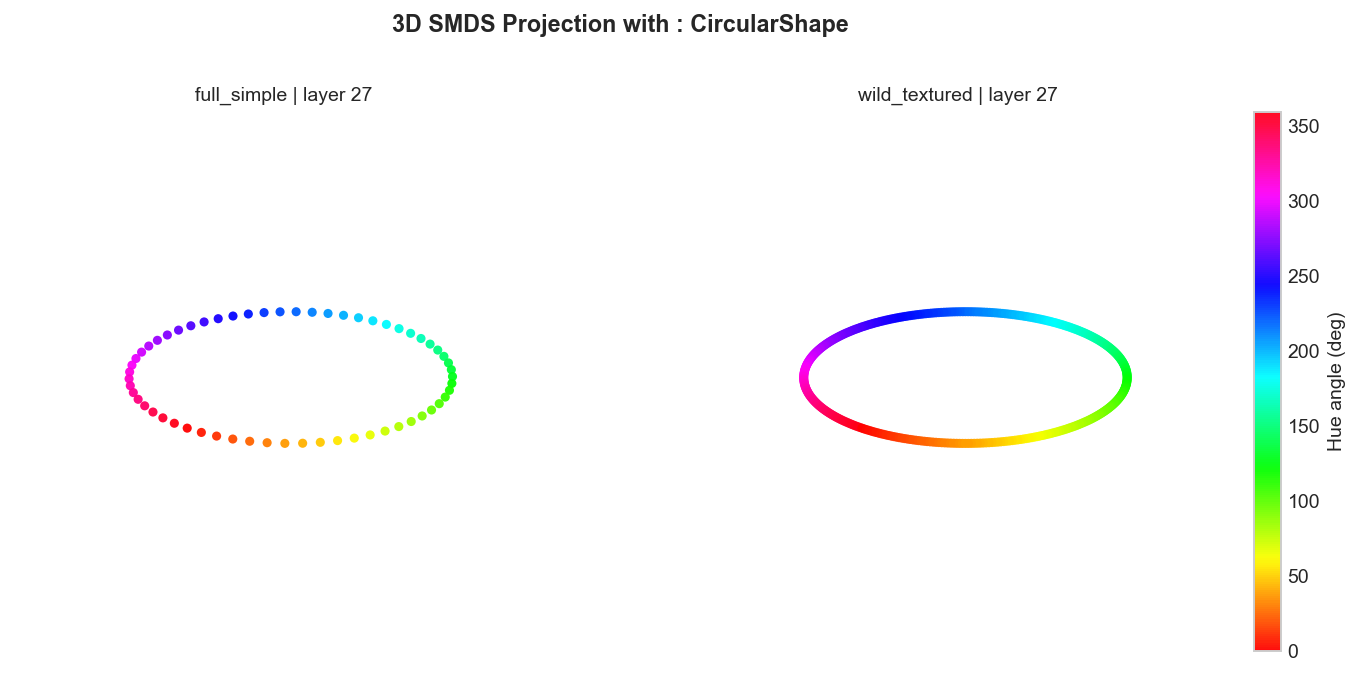

In [67]:
def build_template_3d(angles_deg: np.ndarray, shape_name: str) -> np.ndarray:
    hue = (np.asarray(angles_deg, dtype=np.float64) % 360.0) / 360.0
    if shape_name == "SemicircularShape":
        theta = np.pi * hue
    else:
        theta = 2.0 * np.pi * hue

    x = np.cos(theta)
    y = np.sin(theta)
    z = np.zeros_like(theta)
    return np.column_stack([x, y, z])

fig = plt.figure(figsize=(12, 5), dpi=140)
for panel_idx, row in enumerate(optimal_layers_df.itertuples(index=False), start=1):
    dataset_name = row.dataset
    optimal_layer = int(row.optimal_layer)
    bundle = scans[dataset_name]
    X_opt = np.asarray(bundle["layer_data"][optimal_layer], dtype=np.float64)
    angles_deg = bundle["angles_deg"]
    template = build_template_3d(angles_deg, global_winner_shape)

    stage_1_3d = UserProvidedSMDSParametrization(y=template, n_components=3, name=f"{dataset_name}_template")
    smds_3d = SupervisedMDS(stage_1=stage_1_3d, alpha=1e-4)
    coords = smds_3d.fit_transform(X_opt, template)

    ax = fig.add_subplot(1, 2, panel_idx, projection="3d")
    sc = ax.scatter(
        coords[:, 0],
        coords[:, 1],
        coords[:, 2],
        c=angles_deg,
        cmap="hsv",
        s=22,
        alpha=0.95,
        edgecolors="none",
    )
    ax.set_title(f"{dataset_name} | layer {optimal_layer}", fontsize=10)
    ax.set_axis_off()
    ax.view_init(elev=24, azim=38)
    ranges = np.ptp(coords, axis=0)
    ranges[ranges == 0.0] = 1.0
    ax.set_box_aspect(ranges)

cbar = fig.colorbar(sc, ax=fig.axes, fraction=0.03, pad=0.02)
cbar.set_label("Hue angle (deg)")
plt.suptitle(f"3D SMDS Projection with : {global_winner_shape}", fontsize=12, weight="bold", y=1.02)
plt.show()


## 9) Causal Intervention: Neural Joystick (Blue -> Red)

For each domain, we train a linear decoder from activations to RGB, then apply latent steering:

$$x_{steered} = x_{blue} + alpha (x_{red} - x_{blue})$$

If hue is causally encoded, decoded output shifts from blue toward red.

,dataset,decoder_mse,decoder_r2,decoded_blue_hue,decoded_steered_hue,decoded_red_hue
0,full_simple,2.029280e-30,1.0,240.0,349.411765,0.0
1,wild_textured,7.226774e-31,1.0,240.0,349.411765,0.0


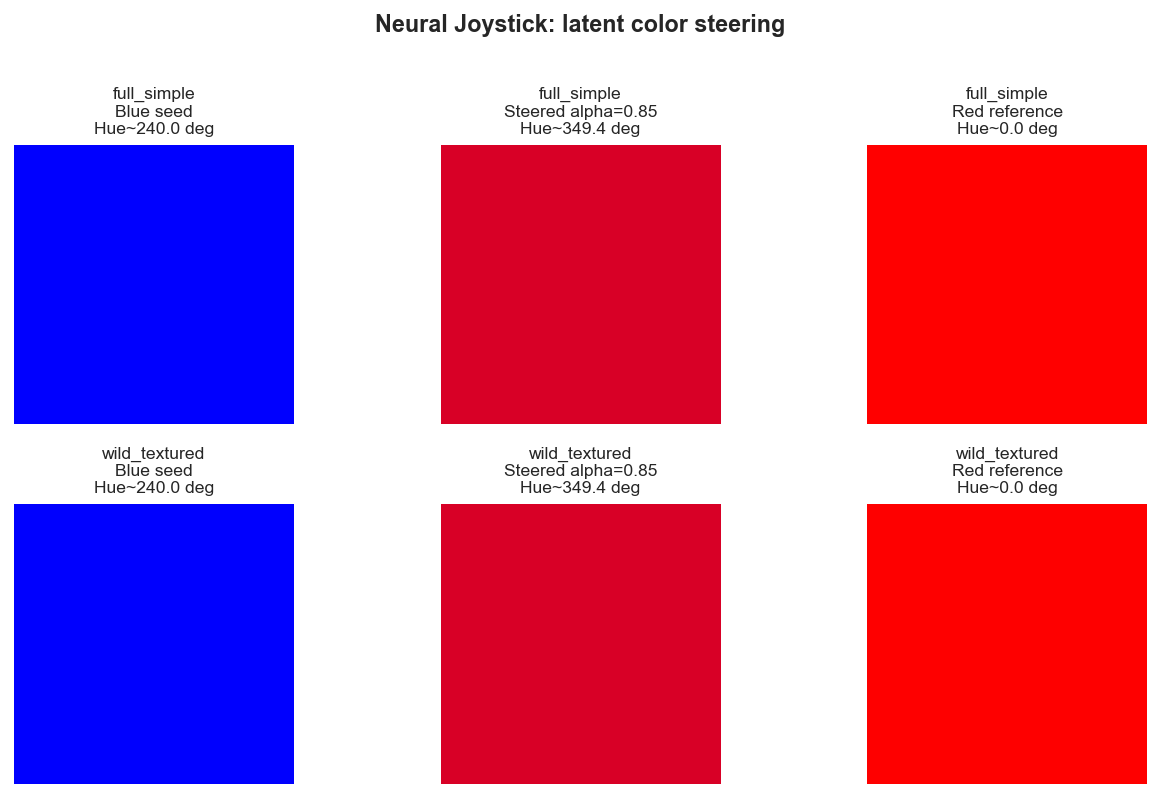

In [68]:
def hue_to_rgb(angle_deg: float) -> tuple[float, float, float]:
    return colorsys.hsv_to_rgb((angle_deg % 360.0) / 360.0, 1.0, 1.0)

def rgb_to_hue_deg(rgb: np.ndarray) -> float:
    r, g, b = np.clip(rgb, 0.0, 1.0)
    hue, _, _ = colorsys.rgb_to_hsv(float(r), float(g), float(b))
    return (hue * 360.0) % 360.0

def mean_vector_at_angle(X: np.ndarray, angles_deg: np.ndarray, target_deg: float) -> np.ndarray:
    circular_delta = np.abs(((angles_deg - target_deg + 180.0) % 360.0) - 180.0)
    idx = np.where(circular_delta == circular_delta.min())[0]
    return X[idx].mean(axis=0)

alpha = 0.85
joystick_rows = []
panel_data = []

for row in optimal_layers_df.itertuples(index=False):
    dataset_name = row.dataset
    optimal_layer = int(row.optimal_layer)
    bundle = scans[dataset_name]
    angles_deg = bundle["angles_deg"]
    X_opt = np.asarray(bundle["layer_data"][optimal_layer], dtype=np.float64)

    y_rgb = np.array([hue_to_rgb(a) for a in angles_deg], dtype=np.float64)
    decoder = LinearRegression()
    decoder.fit(X_opt, y_rgb)
    recon_rgb = np.clip(decoder.predict(X_opt), 0.0, 1.0)

    blue_vec = mean_vector_at_angle(X_opt, angles_deg, 240.0)
    red_vec = mean_vector_at_angle(X_opt, angles_deg, 0.0)
    steered_vec = blue_vec + alpha * (red_vec - blue_vec)

    rgb_blue = np.clip(decoder.predict(blue_vec.reshape(1, -1))[0], 0.0, 1.0)
    rgb_steered = np.clip(decoder.predict(steered_vec.reshape(1, -1))[0], 0.0, 1.0)
    rgb_red = np.clip(decoder.predict(red_vec.reshape(1, -1))[0], 0.0, 1.0)

    hue_blue = rgb_to_hue_deg(rgb_blue)
    hue_steered = rgb_to_hue_deg(rgb_steered)
    hue_red = rgb_to_hue_deg(rgb_red)

    joystick_rows.append(
        {
            "dataset": dataset_name,
            "decoder_mse": float(mean_squared_error(y_rgb, recon_rgb)),
            "decoder_r2": float(r2_score(y_rgb, recon_rgb)),
            "decoded_blue_hue": float(hue_blue),
            "decoded_steered_hue": float(hue_steered),
            "decoded_red_hue": float(hue_red),
        }
    )

    panel_data.append((dataset_name, rgb_blue, rgb_steered, rgb_red, hue_blue, hue_steered, hue_red))

joystick_df = pd.DataFrame(joystick_rows).sort_values("dataset").reset_index(drop=True)
display(joystick_df)

fig, axes = plt.subplots(len(panel_data), 3, figsize=(9.5, 2.8 * len(panel_data)), dpi=140)
if len(panel_data) == 1:
    axes = np.asarray([axes])

for r, item in enumerate(panel_data):
    dataset_name, rgb_blue, rgb_steered, rgb_red, hue_blue, hue_steered, hue_red = item
    columns = [
        ("Blue seed", rgb_blue, hue_blue),
        (f"Steered alpha={alpha:.2f}", rgb_steered, hue_steered),
        ("Red reference", rgb_red, hue_red),
    ]
    for c, (title, rgb, hue) in enumerate(columns):
        patch = np.ones((50, 50, 3), dtype=np.float64) * rgb.reshape(1, 1, 3)
        axes[r, c].imshow(patch)
        axes[r, c].set_title(f"{dataset_name}\n{title}\nHue~{hue:.1f} deg", fontsize=9)
        axes[r, c].axis("off")

plt.suptitle("Neural Joystick: latent color steering", fontsize=12, weight="bold", y=1.01)
plt.tight_layout()
plt.show()


## 10) Expanded Neural Joystick Examples

We expand the joystick with:
- Multiple steering directions (`Blue→Red`, `Red→Green`, `Green→Blue`)
- Alpha sweeps to visualize controllability curves
- Additional color-swatch trajectories for qualitative examples


,dataset,pair,source_deg,target_deg,alpha,decoded_hue,target_error_deg
0,full_simple,Blue→Red,240.0,0.0,-0.25,240.0,-1.200000e+02
1,full_simple,Blue→Red,240.0,0.0,0.00,240.0,-1.200000e+02
2,full_simple,Blue→Red,240.0,0.0,0.25,260.0,-1.000000e+02
3,full_simple,Blue→Red,240.0,0.0,0.50,300.0,-6.000000e+01
4,full_simple,Blue→Red,240.0,0.0,0.75,340.0,-2.000000e+01
5,full_simple,Blue→Red,240.0,0.0,1.00,0.0,0.000000e+00
6,full_simple,Blue→Red,240.0,0.0,1.25,0.0,0.000000e+00
7,full_simple,Red→Green,0.0,120.0,-0.25,0.0,-1.200000e+02
8,full_simple,Red→Green,0.0,120.0,0.00,0.0,-1.200000e+02
9,full_simple,Red→Green,0.0,120.0,0.25,20.0,-1.000000e+02


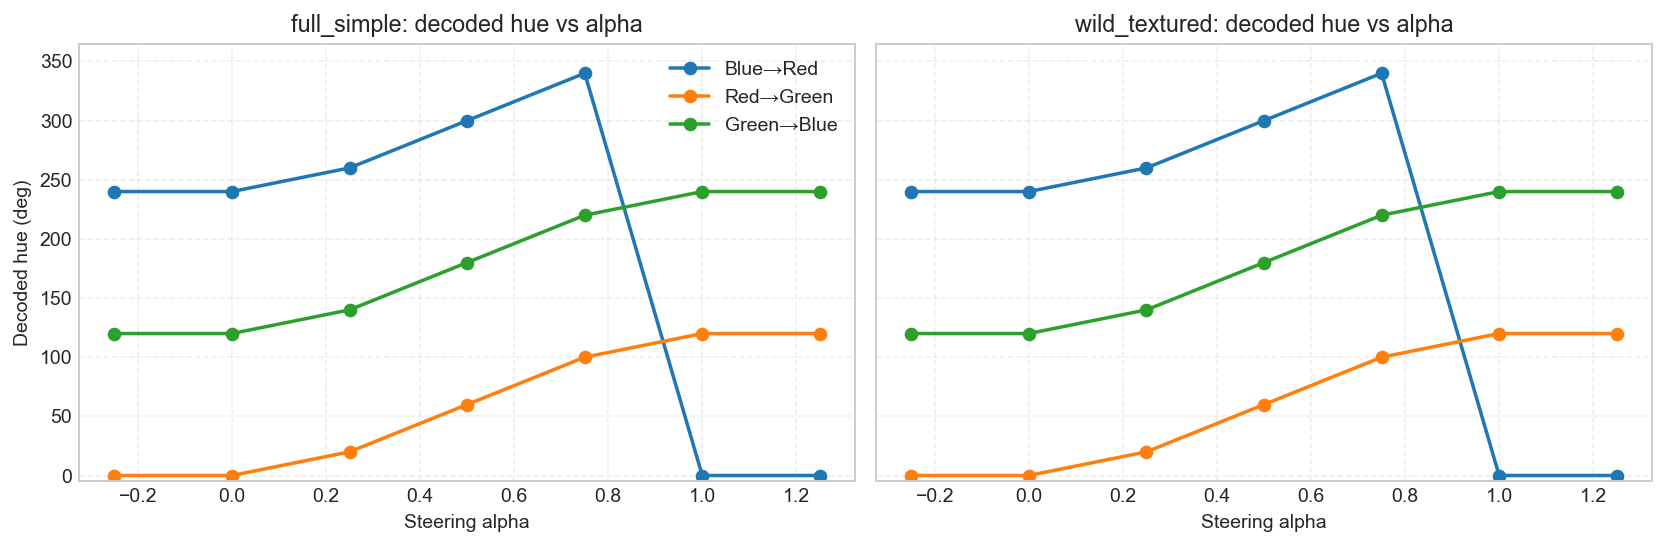

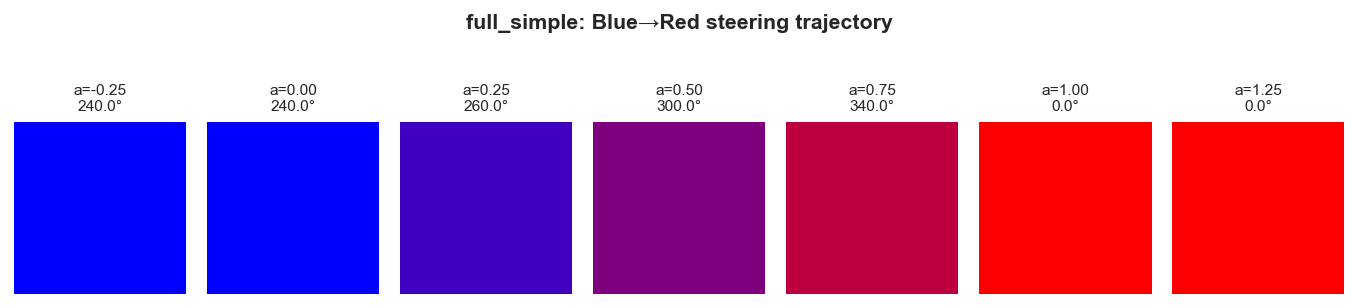

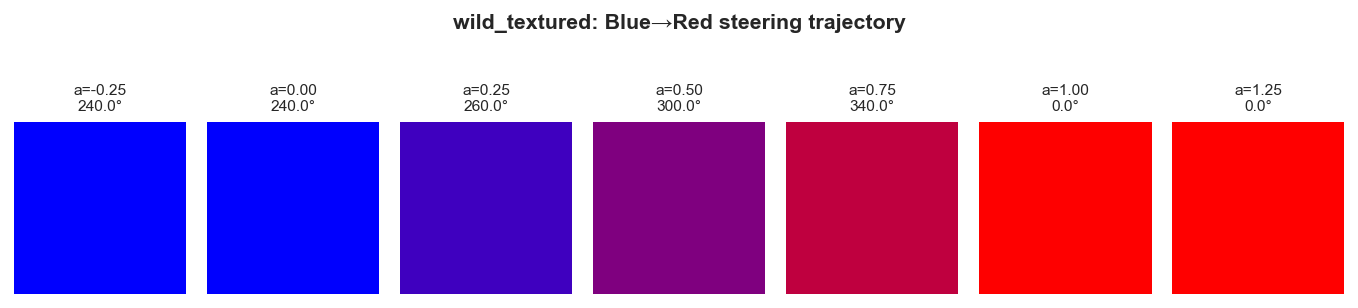

,dataset,pair,alpha,mean_abs_target_error
0,full_simple,Blue→Red,-0.25,120.0
1,full_simple,Blue→Red,0.00,120.0
2,full_simple,Blue→Red,0.25,100.0
3,full_simple,Blue→Red,0.50,60.0
4,full_simple,Blue→Red,0.75,20.0
5,full_simple,Blue→Red,1.00,0.0
6,full_simple,Blue→Red,1.25,0.0
7,full_simple,Green→Blue,-0.25,120.0
8,full_simple,Green→Blue,0.00,120.0
9,full_simple,Green→Blue,0.25,100.0


In [74]:
def circular_hue_error(pred_deg: float, target_deg: float) -> float:
    return float(((pred_deg - target_deg + 180.0) % 360.0) - 180.0)

steering_pairs = [
    (240.0, 0.0, "Blue→Red"),
    (0.0, 120.0, "Red→Green"),
    (120.0, 240.0, "Green→Blue"),
]
alphas = np.array([-0.25, 0.00, 0.25, 0.50, 0.75, 1.00, 1.25], dtype=np.float64)

expanded_rows = []
swatch_cache = []

for row in optimal_layers_df.itertuples(index=False):
    dataset_name = row.dataset
    optimal_layer = int(row.optimal_layer)
    bundle = scans[dataset_name]

    X_opt = np.asarray(bundle["layer_data"][optimal_layer], dtype=np.float64)
    angles = np.asarray(bundle["angles_deg"], dtype=np.float64)
    y_rgb = np.array([hue_to_rgb(a) for a in angles], dtype=np.float64)

    decoder = LinearRegression()
    decoder.fit(X_opt, y_rgb)

    for source_deg, target_deg, label in steering_pairs:
        source_vec = mean_vector_at_angle(X_opt, angles, source_deg)
        target_vec = mean_vector_at_angle(X_opt, angles, target_deg)
        direction = target_vec - source_vec

        for alpha_val in alphas:
            steered_vec = source_vec + alpha_val * direction
            rgb_out = np.clip(decoder.predict(steered_vec.reshape(1, -1))[0], 0.0, 1.0)
            hue_out = rgb_to_hue_deg(rgb_out)
            err = circular_hue_error(hue_out, target_deg)

            expanded_rows.append(
                {
                    "dataset": dataset_name,
                    "pair": label,
                    "source_deg": source_deg,
                    "target_deg": target_deg,
                    "alpha": float(alpha_val),
                    "decoded_hue": float(hue_out),
                    "target_error_deg": float(err),
                }
            )

            if label == "Blue→Red":
                swatch_cache.append((dataset_name, float(alpha_val), rgb_out, float(hue_out)))

expanded_df = pd.DataFrame(expanded_rows)
display(expanded_df.head(18))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=140, sharey=True)
for ax, dataset_name in zip(axes, sorted(expanded_df["dataset"].unique())):
    sub = expanded_df[expanded_df["dataset"] == dataset_name]
    for _, _, label in steering_pairs:
        part = sub[sub["pair"] == label].sort_values("alpha")
        ax.plot(part["alpha"], part["decoded_hue"], marker="o", linewidth=1.8, label=label)
    ax.set_title(f"{dataset_name}: decoded hue vs alpha")
    ax.set_xlabel("Steering alpha")
    ax.grid(True, linestyle="--", alpha=0.35)
axes[0].set_ylabel("Decoded hue (deg)")
axes[0].set_ylim(-5, 365)
axes[0].legend(loc="best")
plt.tight_layout()
plt.show()

# Swatch trajectories for Blue→Red
for dataset_name in sorted(expanded_df["dataset"].unique()):
    entries = [item for item in swatch_cache if item[0] == dataset_name]
    entries = sorted(entries, key=lambda t: t[1])

    fig, axes = plt.subplots(1, len(entries), figsize=(1.4 * len(entries), 2.6), dpi=140)
    if len(entries) == 1:
        axes = [axes]

    for ax, (_, alpha_val, rgb_out, hue_out) in zip(axes, entries):
        patch = np.ones((40, 40, 3), dtype=np.float64) * rgb_out.reshape(1, 1, 3)
        ax.imshow(patch)
        ax.set_title(f"a={alpha_val:.2f}\n{hue_out:.1f}°", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{dataset_name}: Blue→Red steering trajectory", fontsize=11, weight="bold")
    plt.tight_layout()
    plt.show()

summary_expanded = (
    expanded_df.groupby(["dataset", "pair", "alpha"])
    .agg(mean_abs_target_error=("target_error_deg", lambda s: float(np.mean(np.abs(s)))))
    .reset_index()
)
display(summary_expanded.head(18))
